In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [3]:
import deepmatcher as dm
import pandas as pd

In [4]:
walmartamazon_hybrid = dm.MatchingModel(attr_summarizer='hybrid')
walmartamazon_hybrid.load_state('../../models/walmartamazon_hybrid.pth')

In [7]:
from utils.intermediate_layer_extraction import return_layer_input

In [8]:
testneg_classifier_inputs,testneg_ids = return_layer_input('../../Structured/Walmart-Amazon/','test_negatives',
                                                  batch_size=128,model=walmartamazon_hybrid,
                                                   layer=walmartamazon_hybrid.classifier,
                                                  device=-1)

In [9]:
testpos_classifier_inputs,testpos_ids = return_layer_input('../../Structured/Walmart-Amazon/','test_positives',
                                                  batch_size=128,model=walmartamazon_hybrid,
                                                  layer=walmartamazon_hybrid.classifier,
                                                  device=-1)

In [10]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/Walmart-Amazon/','negatives',
                                                  batch_size=512,model=walmartamazon_hybrid,
                                                   layer=walmartamazon_hybrid.classifier,
                                                  device=-1)

In [11]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/Walmart-Amazon/','positives',
                                                  batch_size=512,model=walmartamazon_hybrid,
                                                  layer=walmartamazon_hybrid.classifier,
                                                  device=-1)

In [12]:
walmartamazon_hybrid = walmartamazon_hybrid.cuda()

## Ri discovery

### Negative samples analysis

In [14]:
from utils.ri_calculator import computeRi

In [15]:
attributes =['title','category','brand','modelno','price']
classifier_len = len(pos_classifier_inputs[0][0])
attribute_len = int(classifier_len/len(attributes))

In [16]:
neg_ri,neg_ri_norms = computeRi(walmartamazon_hybrid.classifier,attributes,testneg_classifier_inputs,
                               attribute_len,1)

100%|██████████| 128/128 [00:14<00:00,  8.57it/s]


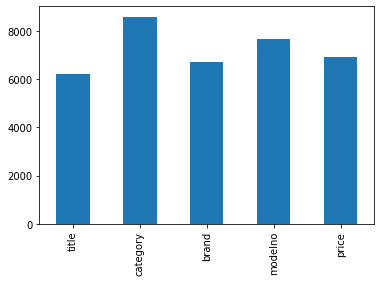

In [18]:
negatives_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
negatives_variation_df.sum(numeric_only=True).plot.bar()

In [19]:
negatives_variation_df.to_csv('experiment_results/testnegatives_ri_hybrid.csv',index=False)

### Positive samples analysis

In [20]:
pos_ri, pos_ri_norms = computeRi(walmartamazon_hybrid.classifier,attributes,testpos_classifier_inputs,
                                attribute_len,0)

100%|██████████| 65/65 [00:07<00:00,  8.73it/s]


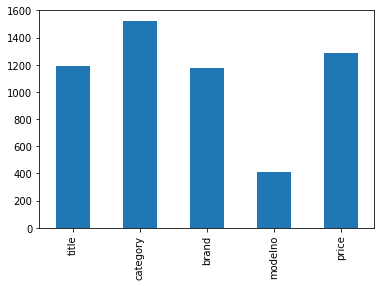

In [21]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum(numeric_only=True).plot.bar()

In [22]:
positives_variation_df.to_csv('experiment_results/testpositives_ri_hybrid.csv',index=False)

## Nearest neighbors

In [24]:
from utils.distance_measures import calculate_nearest_neighbors_onAttributes

In [25]:
positives_nn = calculate_nearest_neighbors_onAttributes(testpos_classifier_inputs,testpos_ids,pos_ri,
                                                       neg_classifier_inputs,neg_ids,attributes,attribute_len
                                                       ,min_similarity=0.5)

100%|██████████| 65/65 [00:00<00:00, 77.98it/s]


In [26]:
negatives_nn = calculate_nearest_neighbors_onAttributes(testneg_classifier_inputs,testneg_ids,
                                                              neg_ri,pos_classifier_inputs,
                                                              pos_ids,attributes,attribute_len,
                                                       min_similarity=0.5)

100%|██████████| 128/128 [00:00<00:00, 543.71it/s]


In [27]:
positives_nn.to_csv('experiment_results/testpos_nn_hybrid_withfilter.csv',index=False)
negatives_nn.to_csv('experiment_results/testneg_nn_hybrid_withfilter.csv',index=False)